#### Importing modules

In [5]:
import os
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('max_columns', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from datetime import datetime
from IPython.display import clear_output as co

from sklearn.preprocessing import binarize 
from sklearn.metrics import classification_report as cr
import sklearn.metrics as metrics

from cv_samplers import GroupUnderSampleSplit, print_cls_cnt, print_intra_cls_cnt, target_categorical_distribution, categorical_undersampling

from sklearn.utils import all_estimators; classifiers = dict(all_estimators('classifier'))
from imblearn.ensemble import ( # Random under sample integrated ensemble models
    BalancedBaggingClassifier as BBC,
    BalancedRandomForestClassifier as BRFC,
    RUSBoostClassifier as RUSBC
)
from sklearn.ensemble import ( # Ensemble models
    GradientBoostingClassifier as GBC, RandomForestClassifier as RFC
)

In [6]:
from sklearn.linear_model import (  # Linear models
    LogisticRegressionCV as LRCV, RidgeClassifierCV as RCCV
)

from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate as CV
from sklearn.decomposition import PCA

from sklearn import metrics

#### Defining functions and performance metrics

In [47]:
def cv_df(cv_res, scoring):
    return pd.DataFrame({scr: cv_res['test_'+scr] for scr in scoring})


class IntraClassRandomUnderSample:

    def __init__(self,
        minority_prct=1,   # controls intra class majority/minority percentage inside outer minority class. None corresponds to original intra class percentage.
        minority_size=1, # percentage of maximum size of minority class sample having intra 'minority_prct' majority/minority class ratio
        majority_prct=1,
        majority_size=1,
        reset_index=False,
    ):
        self.minority_prct = minority_prct
        self.minority_size = minority_size
        self.majority_prct = majority_prct
        self.majority_size = majority_size
        self.reset_index = reset_index
        
    def n_splits(self, _x, _y, groups, n_splits=5, shuffle=True, replace=False, random_state=None, reset_index=False):
        cv = []            
        for i in range(n_splits):
            co(wait=True); print(f'Performing cross validation splits. {i}/{n_splits} splits performed.')
            rs = random_state + i if random_state is not None else None
            xt, xe, yt, ye = self.split(_x, _y, groups, shuffle, replace, random_state=rs)
            cv.append((yt.index.tolist(), ye.index.tolist()))
        print(f'Done! {n_splits} cv splits performed.')
        return cv
        
    def split(self, _x, _y, groups, shuffle=True, replace=False, random_state=None):

        x, y, _groups = _x.copy(), _y.copy(), groups.copy()
        if self.reset_index:
            for Z in (x, y, _groups): Z.reset_index(drop=True, inplace=True) 
        pred_inc = pd.concat([y, _groups], 1).reset_index().set_index([y.name, _groups.name])
        if shuffle: pred_inc = pred_inc.sample(pred_inc.shape[0], replace=False, random_state=random_state)
        cls_cnt = pred_inc.reset_index().groupby(pred_inc.index.names).count()

        index_mino_i = [(0,1), (1,1)]
        prct_i = [self.majority_prct, self.minority_prct]
        size_i = [self.majority_size, self.minority_size]

        n_samples_i = []
        for index, prct, size in zip(index_mino_i, prct_i, size_i):
            n_samples_i += [int(round(cls_cnt.loc[(index)]['index'] * p)) for p in [prct * size, size]]  # (0,0), (0,1) OR (1,0), (1,1)
        train_index = []
        index_i = [(0,0), (0,1), (1,0), (1,1)]
        for index, n_samples in zip(index_i, n_samples_i):
            train_index += pred_inc.loc[index].sample(n_samples, replace=replace, random_state=random_state)['index'].tolist()
        test_index = list(set(y.index.tolist()).difference(train_index))

        if shuffle:
            rand_gen = np.random.default_rng(random_state)
            rand_gen.shuffle(train_index); rand_gen.shuffle(test_index)

        return x.loc[train_index], x.loc[test_index], y.loc[train_index], y.loc[test_index]

In [67]:
recall_0, recall_1 = (metrics.make_scorer(metrics.recall_score, pos_label=i) for i in (0, 1))
scoring = {
#     'accuracy': 'accuracy',
    'f1':'f1', #'f1_macro': 'f1_macro',
    'recall_macro': metrics.make_scorer(metrics.recall_score, average='macro'),
#     'precision_macro': 'precision_macro',
    'recall_0': recall_0, 'recall_1': recall_1,
#     'precision_0': precision_0, 'precision_1': precision_1,
}

---
# LOADING DATA

In [8]:
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)
data.drop('ID_ALUNO', 1, inplace=True)

# Loading data information dictionaries
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining target variables corresponding to each student grade
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
grade = 5
target = targets[grade]

#### List different types of features
ids = data.columns[:10].tolist()
questions = data.columns[10:64].tolist()
grades = data.columns[64:].tolist()

---
# DATA TRANSFORMATION

In [9]:
# eliminate rows where the target variable value is missing. obs: last label represent missing values (Label 3)
modeling_data = data[data[target]!=data[target].max()].copy()
# target variable binary conversion
modeling_data[target] = binarize(modeling_data[[target]], threshold=0.5).reshape(-1)

# reset data index
modeling_data.reset_index(drop=True)

# define X and Y
Y = modeling_data[target].copy()
X = modeling_data.drop(target, 1)

# FILLING MISSING VALUES WITH VARIABLES' MEANS
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True)
    
# target variable class count
display(Y.value_counts().rename('Target variable class count').to_frame())

,Target variable class count
0,397232
1,50087


---
# BASE LINE SCHOOL ABANDONMENT CLASSIFICATION MODEL
#### Assume the test universe is balanced

### Undersample Split data

In [795]:
guss = GroupUnderSampleSplit(
    train_size=0.04, train_prct=1,
    test_size=0.95, test_prct=1,# key_col='ID_TURMA',
    random_state=0,
    reset_index=False,
    remove_duplicates=True,
    verbose=1
)
# xt, xe, yt, ye = guss.undersample(X, Y, cnt=None, shuffle=True, random_state=0)
xt, xe, yt, ye = guss.train_test_undersample(X, Y, cnt=None, shuffle=True, random_state=0)
t_index, e_index = yt.index.to_list(), ye.index.to_list()
print_cls_cnt(Y, t_index, e_index)

,Train set,Test set
Class,,
1,2003,47583
0,2003,47583


### Fit, predict, score base line model for entire remaining dataset (test data)

In [910]:
baseline = BRFC()

baseline_fit = baseline.fit(xt, yt)
yp = pd.Series(baseline_fit.predict(xe), index=xe.index)
yprob = baseline_fit.predict_proba(xe)

print(metrics.classification_report(ye, yp))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     47583
           1       0.69      0.70      0.69     47583

    accuracy                           0.69     95166
   macro avg       0.69      0.69      0.69     95166
weighted avg       0.69      0.69      0.69     95166



In [797]:
ye.values[:10] # true values

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [798]:
yp.values[:10] # baseline prediction

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

# MODELING CORRECT/INCORRECT PREDICTION VARIABLE

## Define 'incorrect prediction' variable

In [799]:
y_inc = ( yp != ye ).astype('int64').rename('Incorrect Prediction'); y_inc.values[:10]
x_inc = xe.copy()

print_intra_cls_cnt(ye, groups=y_inc, prct=True)

outer class,1,0,total - inner,total - outer,0 (% - outer),1 (% - outer),0 (% - inner),1 (% - inner)
inner class (target),,,,,,,,
0,14769,32814,47583,66145,49.6,50.4,69.0,31.0
1,14252,33331,47583,29021,50.9,49.1,70.0,30.0


## Split data with inner and outer stratification

In [824]:
icrus = IntraClassRandomUnderSample(
    minority_prct=1., minority_size=0.7/20 * 3,
    majority_prct=1., majority_size=0.3/20 * 3,
    reset_index=False
)
xt_inc, _xe_inc, yt_inc, _ye_inc = icrus.split(
    x_inc, y_inc, ye,
    shuffle=True, replace=False,
    random_state=0,
)
icrus = IntraClassRandomUnderSample(
    minority_prct=1., minority_size=0.7/20 * 25,
    majority_prct=1, majority_size=0.3/20 * 25,
    reset_index=False
)
xe_inc, xe_inc_, ye_inc, ye_inc_ = icrus.split(
    _xe_inc, _ye_inc, ye.loc[_ye_inc.index],
    shuffle=True, replace=False,
    random_state=0,
)
# from sklearn.model_selection import train_test_split as tts
# xt_inc, xe_inc, yt_inc, ye_inc = tts(x_inc, y_inc, test_size=0.9, shuffle=True, random_state=0)
#### Extracting true values and baseline predictions for test data of 'incorrectness prediction' modeling
ye_e = ye.loc[ye_inc.index].copy() # true target values
yp_e = yp.loc[ye_inc.index].copy() # baseline target prediction
ye_t = ye.loc[yt_inc.index].copy() # true target values
yp_t = yp.loc[yt_inc.index].copy() # baseline target prediction
print_cls_cnt(y_inc, yt_inc.index, ye_inc.index)
print_intra_cls_cnt(ye_t, groups=yt_inc, prct=False)
print_intra_cls_cnt(ye_e, groups=ye_inc, prct=False)

<ipython-input-47-d232983ac946>:70: PerformanceWarning: indexing past lexsort depth may impact performance.
  train_index += pred_inc.loc[index].sample(n_samples, replace=replace, random_state=random_state)['index'].tolist()


,Train set,Test set
Class,,
0,3000,23874
1,2992,22322


outer class,1,0,total - inner,total - outer
inner class (target),,,,
0,1496,1500,2996,3000
1,1496,1500,2996,2992


outer class,0,1,total - inner,total - outer
inner class (target),,,,
0,11937,11161,23098,23874
1,11937,11161,23098,22322


## Fit definitive model of incorrect prediction

In [825]:
side_model = BRFC()
side_model_fit = side_model.fit(xt_inc, yt_inc)

## Predict and score for remaining test data (excluding baseline & 'incorrect prediction' training data)

* Different thresholds for each class
* Threshold for abs. prob. difference

In [845]:
yp_inc = pd.Series(side_model_fit.predict(xe_inc), index=xe_inc.index) # incorrectness prediction score for entire test data

### Predict probabilities for test data

In [827]:
yprob_inc = pd.DataFrame(side_model_fit.predict_proba(xe_inc), index=xe_inc.index)
yprob_inc['prob diff'] = yprob_inc[1] - 0.5
yprob_inc['abs prob diff'] = np.abs(yprob_inc['prob diff'])
yprob_inc['pred'] = yp_inc

### Classification report

In [828]:
print(metrics.classification_report(ye_inc, yp_inc))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58     23874
           1       0.56      0.59      0.57     22322

    accuracy                           0.57     46196
   macro avg       0.58      0.58      0.57     46196
weighted avg       0.58      0.57      0.57     46196



### Classification report per target classes

In [829]:
cls_0_msk = ye_inc.index.isin(ye[ye==0].index)
cls_1_msk = ye_inc.index.isin(ye[ye==1].index)

### Majority class classification report

In [830]:
print(metrics.classification_report(ye_inc[cls_0_msk], yp_inc[cls_0_msk]))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57     11937
           1       0.55      0.59      0.57     11161

    accuracy                           0.57     23098
   macro avg       0.57      0.57      0.57     23098
weighted avg       0.57      0.57      0.57     23098



### Minority class classification report

In [831]:
print(metrics.classification_report(ye_inc[cls_1_msk], yp_inc[cls_1_msk]))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58     11937
           1       0.56      0.59      0.57     11161

    accuracy                           0.58     23098
   macro avg       0.58      0.58      0.58     23098
weighted avg       0.58      0.58      0.58     23098



# CORRECT BASELINE PREDICTION USING 'INCORRECT PREDICTION' MODEL

### Assuming that we have a balenced test sample, general learning can be improved by this technique only if the secondary model ('error prediction' model) accuracy is higher then the primary model's (target variable model) accuracy.

#### Obs: Score for entire test data and also for remaining (unseen) test data only

* True values: ye
* Baseline prediction: yp
* True incorrectness values: y_inc
* Incorrectness prediction: yp_inc

### Flip baseline predictions based on 'incorrectness' model prediction

In [832]:
def flip_prediction(yprob=None, thresholds=[0, 0.5], percentile=False):
    if probs is None:
        probs = flip_msk
        if percentile:
            thresholds = [np.percentile(probs, thresholds[i]*100) for i in [0,1]]
    elif percentile:
        thresholds = [np.percentile(probs[flip_msk==i], thresholds[i]*100) for i in [0,1]]
    y_flip = []
    for yp_i, flip, prob in zip(yp.copy(), flip_msk, probs):
        if flip:
            if prob >= thresholds[1]: yi = int(not yp_i)
            else: yi = yp_i
        else:
            if prob >= thresholds[0]: yi = yp_i
            else: yi = int(not yp_i)
        y_flip.append(yi)
    return pd.Series(y_flip, index=yp.index, dtype='int64', )

In [833]:
yp_flip = flip_prediction(yp_e.copy(), flip_msk=yp_inc, probs=None, thresholds=[0, 0.5], percentile=False)
yprob_flip = flip_prediction(yp_e.copy(), flip_msk=yp_inc, probs=yprob_inc['abs prob diff'], thresholds=[0.3, 0.0], percentile=True)

### Score corrected predictions

In [834]:
print(metrics.classification_report(ye_e, yprob_flip)) # flipped prediction based on confidence threshold

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     23098
           1       0.57      0.57      0.57     23098

    accuracy                           0.57     46196
   macro avg       0.57      0.57      0.57     46196
weighted avg       0.57      0.57      0.57     46196



In [835]:
print(metrics.classification_report(ye_e, yp_flip)) # flipped prediction

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     23098
           1       0.57      0.58      0.58     23098

    accuracy                           0.57     46196
   macro avg       0.57      0.57      0.57     46196
weighted avg       0.57      0.57      0.57     46196



In [836]:
print(metrics.classification_report(ye_e, yp_e)) # baseline prediction

              precision    recall  f1-score   support

           0       0.52      0.52      0.52     23098
           1       0.52      0.52      0.52     23098

    accuracy                           0.52     46196
   macro avg       0.52      0.52      0.52     46196
weighted avg       0.52      0.52      0.52     46196



## Threhsold Recall surface

In [740]:
n_bins = 11

# Calculate scores for threshold grid
bins = np.linspace(0, 1, n_bins)
scrs = []
for bin0 in bins:
    for bin1 in bins:
        yprob_flip = flip_prediction(yp_e.copy(), flip_msk=yp_inc, probs=yprob_inc['abs prob diff'], thresholds=[bin0, bin1], percentile=True)
        CR = metrics.classification_report(ye_e, yprob_flip, output_dict=True)
        scrs.append([bin0, bin1, CR['accuracy'], CR['macro avg']['recall'], CR['0']['recall'], CR['1']['recall']])
p_scrs = pd.DataFrame(scrs, columns=['threshold 0', 'threshold 1', 'acc', 'recall macro', 'recall 0', 'recall 1'])

# define variables to plot
xx = p_scrs['threshold 0'].values.reshape(n_bins, n_bins)
yy = p_scrs['threshold 1'].values.reshape(n_bins, n_bins)
zz = p_scrs['recall macro'].values.reshape(n_bins, n_bins)
ww = p_scrs['recall 0'].values.reshape(n_bins, n_bins)
kk = p_scrs['recall 1'].values.reshape(n_bins, n_bins)

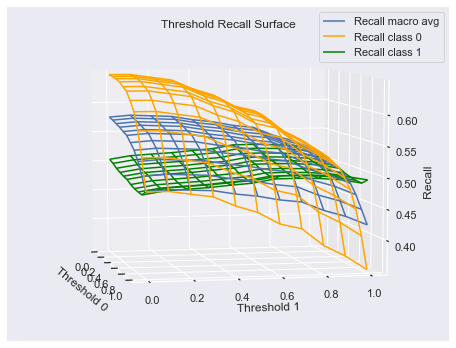

In [747]:
# plot surface for multiple angles
for angle in range(0, 360, 12):
    
    fig = plt.figure(figsize=(6.5, 5), tight_layout=True)
    ax = fig.add_subplot(projection='3d')
    ax.plot_wireframe(xx, yy, zz, label='Recall macro avg')
    ax.plot_wireframe(xx, yy, ww, color='orange', label='Recall class 0')
    ax.plot_wireframe(xx, yy, kk, color='green', label='Recall class 1')
    ax.set(xlabel='Threshold 0', ylabel='Threshold 1', zlabel='Recall', title='Threshold Recall Surface')
    ax.legend()
    ax.view_init(7, angle)
    plt.show(); plt.pause(.1); co(wait=True)

#### Check result

In [742]:
ye_e.values[:10] # true target values

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [743]:
yp_e.values[:10] # baseline target prediction

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

In [744]:
ye_inc.values[:10] # true incorrectness

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

In [745]:
yp_inc.values[:10] # incorrectness prediction

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int64)

In [746]:
yp_flip.values[:10] # baseline prediction flipped by incorrectness prediction

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

---
# EXTRA: EXPLANATORY DATA VISUALIZATION

## Compare models of incorrect prediction

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

DTC = classifiers['DecisionTreeClassifier']
LRCV = classifiers['LogisticRegressionCV']
# DC = classifiers['DummyClassifier']
KNN = classifiers['KNeighborsClassifier']

estimators = [('clf', GBC())]
pipe = Pipeline(estimators)
param_grid={'clf': [
        GBC(), BRFC(), DTC(max_depth=2), DC(), KNN()
]}
reset_index_map = pd.Series(range(y_inc.shape[0]), index=y_inc.index)
cv = [(reset_index_map[yt_inc.index], reset_index_map[ye_inc.index])]

GS = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='recall_macro', n_jobs=-1, pre_dispatch='all', verbose=1)
gs_fit = GS.fit(x_inc, y_inc)

In [98]:
GS.best_score_

0.592078725561711

In [99]:
GS.best_estimator_

Pipeline(steps=[('clf', GradientBoostingClassifier())])

In [100]:
cv_res = pd.DataFrame(GS.cv_results_)

In [101]:
cv_res[['param_clf', 'mean_test_recall_macro']]

,param_clf,mean_test_recall_macro
0,GradientBoostingClassifier(),0.592079
1,BalancedRandomForestClassifier(),0.587548
2,DecisionTreeClassifier(max_depth=2),0.551438
3,DummyClassifier(),0.500000
4,KNeighborsClassifier(),0.500719


## Learning curve

In [54]:
icrus = IntraClassRandomUnderSample(
    minority_prct=1., minority_size=0.7/20 * 5,
    majority_prct=1., majority_size=0.3/20 * 5,
    reset_index=True
)
lc_cv = icrus.n_splits(
    x_inc, y_inc, ye, n_splits=5,
    shuffle=True, replace=False,
    reset_index=True,
    random_state=0,
)

Performing cross validation splits. 4/5 splits performed.
Done! 5 cv splits performed.


In [63]:
from sklearn.model_selection import learning_curve as lc
model_lc = lc(
    GBC(), x_inc, y_inc,
    train_sizes=np.linspace(0.1, 1, 7)**2.5,
    cv=lc_cv, scoring='recall_macro',
    n_jobs=-1, pre_dispatch='all',
    verbose=5, shuffle=True, random_state=0,
)

[learning_curve] Training set sizes: [  31  312 1010 2240 4094 6653 9988]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  35 | elapsed:    3.0s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:   12.1s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:   18.5s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   25.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   34.9s finished


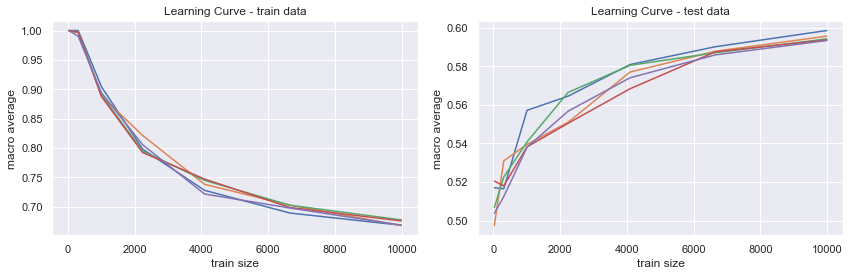

In [64]:
train_lc, test_lc = (pd.DataFrame(model_lc[i], index=model_lc[0]) for i in [1,2])

fig, ax = plt.subplots(1,2, figsize=(12,4), tight_layout=True)
ax[0].plot(train_lc); ax[1].plot(test_lc)
for i, t in zip([0,1], ['train', 'test']):
    ax[i].set(xlabel='train size', ylabel='macro average', title=f'Learning Curve - {t} data')

plt.show()

---
# Model 'incorrect prediction' variable per class

In [146]:
cats = [ ((0 if ye_i==yp_i else 1) if ye_i==0 else (2 if ye_i==yp_i else 3))  for ye_i, yp_i in zip(ye, yp)]
y_inc_cls = pd.Series(cats, index=ye.index).astype('int64').rename('Incorrect Prediction'); y_inc.values[:10]

print_cls_cnt(y_inc_cls, y_inc_cls.index, y_inc_cls.index)

,Train set,Test set
Class,,
2,31443,31443
0,31141,31141
1,13937,13937
3,13636,13636


In [147]:
guss = GroupUnderSampleSplit(
    train_size=.3, train_prct={0: 10000, 1: 10000, 2: 10000, 3: 10000},
    test_size=.69, test_prct={0: 10000, 1: 10000, 2: 10000, 3: 10000},
    random_state=0,
    reset_index=False,
    verbose=1
)
# Train and test x and y dataframes
xt_inc, xe_inc, yt_inc, ye_inc = guss.train_test_undersample(
    x_inc, y_inc_cls,
    cnt=None, shuffle=True,
    random_state=0
)
print_cls_cnt(y_inc_cls, yt_inc.index, ye_inc.index)

,Train set,Test set
Class,,
3,3000,9857
2,3000,9857
1,3000,9857
0,3000,9857


In [652]:
ye.value_counts() # target classes labels

1    47583
0    47583
Name: TX_RESP_Q049, dtype: int64

In [655]:
y_rec.value_counts() # incorrect guesses labels

1    23164
0    23164
Name: TX_RESP_Q049, dtype: int64

---
# Train model on correct or incorrect guesses only

In [748]:
y_cor = ye[y_inc==0].copy()
y_incor = ye[y_inc==1].copy()
x_cor = xe.loc[y_cor.index].copy()
x_incor = xe.loc[y_incor.index].copy()

In [749]:
y_cor.value_counts(), y_incor.value_counts()

(1    33292
 0    32654
 Name: TX_RESP_Q049, dtype: int64,
 0    14929
 1    14291
 Name: TX_RESP_Q049, dtype: int64)

In [769]:
guss = GroupUnderSampleSplit(
    train_size=.092, train_prct=1,
    random_state=0,
    reset_index=False,
    verbose=1
)
xt_cor, xe_cor, yt_cor, ye_cor = guss.undersample(
    x_cor, y_cor,
    cnt=None, shuffle=True,
    random_state=0
)
guss = GroupUnderSampleSplit(
    train_size=.21, train_prct=1,
    random_state=0,
    reset_index=False,
    verbose=1
)
xt_incor, xe_incor, yt_incor, ye_incor = guss.undersample(
    x_incor, y_incor,
    cnt=None, shuffle=True,
    random_state=0
)

print_cls_cnt(y_cor, yt_cor.index, ye_cor.index)
print_cls_cnt(y_incor, yt_incor.index, ye_incor.index)

,Train set,Test set
Class,,
1,3004,30288
0,3004,29650


,Train set,Test set
Class,,
0,3001,11928
1,3001,11290


In [780]:
model = RUSBC()
modelfit_cor = model.fit(xt_cor, yt_cor) # Fitted using correct guesses train partition only
yp_cor = pd.Series(modelfit_cor.predict(xe_cor), index=xe_cor.index)
model = RUSBC()
modelfit_incor = model.fit(xt_incor, yt_incor) # Fitted using incorrect guesses train partition only
yp_incor = pd.Series(modelfit_incor.predict(xe_incor), index=xe_incor.index)

In [781]:
print(metrics.classification_report(ye_cor, yp_cor))  # Performance predicting remaining (test) correct guesses.

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     29650
           1       0.93      0.92      0.93     30288

    accuracy                           0.93     59938
   macro avg       0.93      0.93      0.93     59938
weighted avg       0.93      0.93      0.93     59938



In [782]:
print(metrics.classification_report(ye_incor, yp_incor))  # Performance predicting remaining (test) incorrect guesses.

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     11928
           1       0.82      0.85      0.83     11290

    accuracy                           0.83     23218
   macro avg       0.83      0.83      0.83     23218
weighted avg       0.83      0.83      0.83     23218



## Scoring 'recombined' prediction

In [792]:
yp_recomb = pd.concat([yp_cor, yp_incor])
recomb_index = yp_cor.index.tolist() + yp_incor.index.tolist()

In [794]:
print(metrics.classification_report(ye.loc[recomb_index], yp_recomb))  # Performance predicting remaining (test) incorrect guesses.

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     41578
           1       0.90      0.90      0.90     41578

    accuracy                           0.90     83156
   macro avg       0.90      0.90      0.90     83156
weighted avg       0.90      0.90      0.90     83156



In [788]:
ye.size

95166

---
# Train model on correct or incorrect guesses predictions only

In [853]:
y_cor = ye.loc[yp_inc.index][yp_inc==0].copy()
y_incor = ye.loc[yp_inc.index][yp_inc==1].copy()
x_cor = xe.loc[y_cor.index].copy()
x_incor = xe.loc[y_incor.index].copy()

In [854]:
y_cor.value_counts(), y_incor.value_counts()

(1    11391
 0    11122
 Name: TX_RESP_Q049, dtype: int64,
 0    11976
 1    11707
 Name: TX_RESP_Q049, dtype: int64)

In [858]:
guss = GroupUnderSampleSplit(
    train_size=.27, train_prct=1,
    random_state=0,
    reset_index=False,
    verbose=1
)
xt_cor, xe_cor, yt_cor, ye_cor = guss.undersample(
    x_cor, y_cor,
    cnt=None, shuffle=True,
    random_state=0
)
guss = GroupUnderSampleSplit(
    train_size=.255, train_prct=1,
    random_state=0,
    reset_index=False,
    verbose=1
)
xt_incor, xe_incor, yt_incor, ye_incor = guss.undersample(
    x_incor, y_incor,
    cnt=None, shuffle=True,
    random_state=0
)

print_cls_cnt(y_cor, yt_cor.index, ye_cor.index)
print_cls_cnt(y_incor, yt_incor.index, ye_incor.index)

,Train set,Test set
Class,,
1,3003,8388
0,3002,8120


,Train set,Test set
Class,,
0,2985,8991
1,2985,8722


In [859]:
model = RUSBC()
modelfit_cor = model.fit(xt_cor, yt_cor) # Fitted using correct guesses train partition only
yp_cor = pd.Series(modelfit_cor.predict(xe_cor), index=xe_cor.index)
model = RUSBC()
modelfit_incor = model.fit(xt_incor, yt_incor) # Fitted using incorrect guesses train partition only
yp_incor = pd.Series(modelfit_incor.predict(xe_incor), index=xe_incor.index)

In [860]:
print(metrics.classification_report(ye_cor, yp_cor))  # Performance predicting remaining (test) correct guesses.

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      8120
           1       0.64      0.59      0.61      8388

    accuracy                           0.62     16508
   macro avg       0.63      0.62      0.62     16508
weighted avg       0.63      0.62      0.62     16508



In [861]:
print(metrics.classification_report(ye_incor, yp_incor))  # Performance predicting remaining (test) incorrect guesses.

              precision    recall  f1-score   support

           0       0.55      0.57      0.56      8991
           1       0.54      0.52      0.53      8722

    accuracy                           0.55     17713
   macro avg       0.55      0.55      0.55     17713
weighted avg       0.55      0.55      0.55     17713



# Predicting with baseline model for classes tresholds

In [1024]:
from sklearn.preprocessing import MinMaxScaler
def predict_threshold(
    yprob=None,
    limit=0,
    thresholds=[0, 0], # percentage of maximum prob. in 'yprob' above which to consider sample to be from eah class and not the other.
    percentile=True # convert thresholds to percentiles of 'yprob' for each class
):
    if percentile:
        thresholds[0] = np.percentile(yprob[yprob<limit], 100 * (1 - thresholds[0]))
        thresholds[1] = np.percentile(yprob[yprob>limit], 100 * thresholds[1])
    else:
        scaler = MinMaxScaler().fit(yprob.to_frame())
        yprob = pd.Series(scaler.transform(yprob.to_frame()).reshape(-1), index=yprob.index)
        limit = scaler.transform([[limit]])[0][0]
        
    y_flip = []
    for prob in yprob:
        if prob > limit:
            if prob >= thresholds[1]:
                yi = 1
            else: yi = 0
        else:
            if prob <= thresholds[0]: 
                yi = 0
            else: yi = 1
        y_flip.append(yi)
    return pd.Series(y_flip, index=yprob.index, dtype='int64')

def threshold_recall_scores(yprob, ye, n_bins=7, order=2, limit=0, percentile=True):
    # Calculate scores for threshold grid
    bins = np.linspace(0, 1, n_bins)**order
    scrs, cnt = [], 0
    for bin0 in bins:
        for bin1 in bins:
            cnt+=1; co(wait=True); print(f'Threshold grid scoring. {cnt}/{len(bins)**2} threshold pairs scored.')
            yp = predict_threshold(yprob, limit, thresholds=[bin0, bin1], percentile=percentile)
            CR = metrics.classification_report(ye, yp, output_dict=True)
            pred_cnt = yp.value_counts()
            scrs.append([
                bin0, bin1,
                CR['accuracy'], CR['macro avg']['recall'],
                CR['0']['recall'], CR['1']['recall'],
            ])
    return pd.DataFrame(scrs, columns=['threshold 0', 'threshold 1', 'acc', 'recall macro', 'recall 0', 'recall 1'])

def plot_recall_surface(p_scrs, append_text=''):
    # define variables to plot
    n_bins = len(p_scrs['threshold 0'].unique())
    xx = p_scrs['threshold 0'].values.reshape(n_bins, n_bins)
    yy = p_scrs['threshold 1'].values.reshape(n_bins, n_bins)
    zz = p_scrs['recall macro'].values.reshape(n_bins, n_bins)
    ww = p_scrs['recall 0'].values.reshape(n_bins, n_bins)
    kk = p_scrs['recall 1'].values.reshape(n_bins, n_bins)

    # plot surface for multiple angles
    for angle in range(0, 360, 12):

        fig = plt.figure(figsize=(7, 5), tight_layout=True)
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(xx, yy, zz, label='Recall macro avg')
        ax.plot_wireframe(xx, yy, ww, color='orange', label='Recall class 0')
        ax.plot_wireframe(xx, yy, kk, color='green', label='Recall class 1')
        ax.set(xlabel='Threshold 0'+append_text, ylabel='Threshold 1'+append_text, zlabel='Recall', title='Threshold Recall Surface')
        ax.legend()
        ax.view_init(7, angle)
        plt.show(); plt.pause(.1); co(wait=True)

In [1019]:
yprob = pd.DataFrame(baseline_fit.predict_proba(xe), index=xe.index)
yprob['prob diff'] = yprob[1] - 0.5
yprob['abs prob diff'] = np.abs(yprob['prob diff'])
yprob['pred'] = yp

In [1020]:
print(cr(ye, yprob['pred']))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     47583
           1       0.69      0.70      0.69     47583

    accuracy                           0.69     95166
   macro avg       0.69      0.69      0.69     95166
weighted avg       0.69      0.69      0.69     95166



## Baseline performance by class tresholds (0-1 scaled thresholds)

#### Score by multiple increasing maximal scaled threshold

In [1035]:
p_scrs = threshold_recall_scores(yprob['prob diff'], ye, n_bins=11, order=2, limit=0., percentile=False)

Threshold grid scoring. 121/121 threshold pairs scored.


C:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


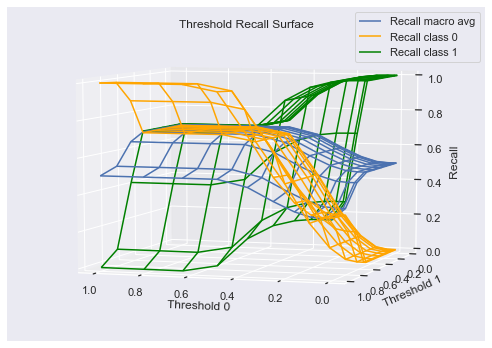

In [ ]:
plot_recall_surface(p_scrs)

## Baseline performance by class tresholds (0-1 percentile thresholds)

#### Score by multiple increasing maximal percentile threshold

#### Obs: When varying the <i>percentile</i> limit of thresholds (case bellow), drawned sample size increases at constant rate

In [1028]:
p_scrs = threshold_recall_scores(yprob['prob diff'], ye, n_bins=11, order=2, limit=0., percentile=True)

Threshold grid scoring. 121/121 threshold pairs scored.


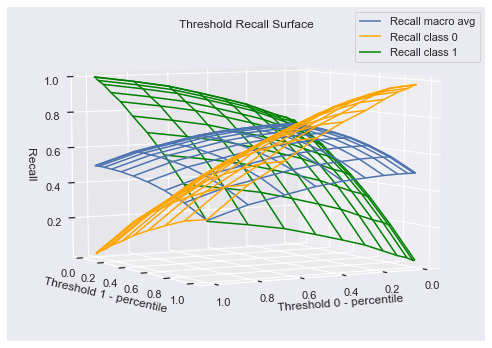

In [ ]:
plot_recall_surface(p_scrs, append_text=' - percentile')

## Classification report for selected threshold pair

In [1071]:
yflip = predict_threshold(yprob['prob diff'], limit=0., thresholds=[0, 0], percentile=True)

In [1072]:
print(cr(ye, yflip))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69     47583
           1       0.68      0.72      0.70     47583

    accuracy                           0.69     95166
   macro avg       0.69      0.69      0.69     95166
weighted avg       0.69      0.69      0.69     95166

